# Cosin Similarity 餘弦相似度(應該也可以用來分群)
1. 敘述性理解: 用在文章上被判斷為相似的文章確實效果都不錯, 但是如果用來分群, 我想threshold設定必須要拉得很低, 否則雜訊點會佔90%以上, 資料維度越高, 我想就是要降低threshold
2. 這裡使用 AgglomerativeClustering(metric='cosine'), 核心距離指標選擇cosine, 效能奇差無比, 文章數壓到1000以下才勉強接受, 而且這個也需要先指定群數..., 而且效果也似乎不太好
3. 自己實作分群遇到無法將群之間的變異數拉到最小, 導致一群會被我分層兩群, 把群間變異數最小化 => 這不就是k-means的原理嗎? sklearn k-means竟然只提供euclidean distance, 目前卡在這一點, 這是分群效果最好的一次實作

In [1]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# 抓出頻果新聞資料
apple78Df = None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
apple78Df

,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...


In [7]:
# 文章數壓到1000以下才勉強接受, 而且這個也需要先指定群數..., 而且效果也似乎不太好
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

vec = TfidfVectorizer(stop_words='english')
X = vec.fit_transform(apple78Df[:1000].term).toarray()
model = AgglomerativeClustering(n_clusters=13, linkage="average", affinity='cosine')
model.fit(X)
r = pd.Series(model.labels_)
r.value_counts()

5     378
0     178
2     142
1     119
6      98
4      46
10     10
11      9
7       6
8       5
12      4
3       3
9       2
dtype: int64

In [9]:
from sklearn import metrics

labels_true, labels = apple78Df[:1000].forum, model.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Homogeneity: 0.337
Completeness: 0.442
V-measure: 0.382
Adjusted Rand Index: 0.201
Adjusted Mutual Information: 0.317
Silhouette Coefficient: 0.009


In [12]:
# 看同樣被列為第5群的資料各是什麼文章?
grp = 5
print(apple78Df[:1000][r == grp].forum.value_counts())
apple78Df[:1000][r == grp]

politics         101
local             96
international     82
finance           32
life              32
forum             21
entertainment      6
strange            3
fashion            2
3c                 1
animal             1
sports             1
Name: forum, dtype: int64


,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...
10,local,【有片】停路中開車門害騎士摔 竟賴給後方駕駛肇事,更新 肇事者 馬路 三寶 摔車 新北市 駕駛 前天 小孩 同學 同學 下車 機車騎士 摔車 ...,駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 駕駛 下車 下車 下...,（更新：新增肇事者罰責） 馬路三寶又害摔車！新北市一名女駕駛，前天載小孩及其同學返家，同學突...,http://www.appledaily.com.tw/realtimenews/arti...
13,local,【被興航撞的小黃現況】運將：嚇到變廢人 一年無收入,更新 復興航空 影片 大難 不死 復興航空 台北 空難 事件 飛安會 報告 蘋果 訪問 復興...,興航 興航 興航 興航 興航 興航 興航 興航 興航 復興航空 復興航空 復興航空 復興航空...,（更新：新增復興航空說法、第3版影片）大難不死必有福？去年發生的復興航空台北空難事件，飛安會...,http://www.appledaily.com.tw/realtimenews/arti...
15,local,【公庫】踢爆！工商團體理監事所屬企業違法記錄全揭露！,本週 包含 工業 商業 工商 工商團體 記者會 行政院 刪除 勞工團體 七天 國定假日 工商...,工商團體 工商團體 工商團體 工商團體 工商團體 工商團體 老闆 老闆 老闆 老闆 勞工團體...,本內容由公庫提供本週一（6月27日），包含工業總會、商業總會與工商協進會，七大工商團體聯合召...,http://www.appledaily.com.tw/realtimenews/arti...
16,local,【更新】算什麼台灣之光 強國山寨UA標MIT,更新 網友 刑事警察 大隊 三民 三民路 早市 仿冒 Under Armour 運動 品牌 ...,仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 服飾 服飾 服飾 服飾 服飾 服...,（更新：增加網友意見）保二總隊刑事警察大隊在高市三民區三民路早市，查獲仿冒UA（Under ...,http://www.appledaily.com.tw/realtimenews/arti...
19,strange,你不知道的麥香紅茶 小瓶才是王道,更新 養樂多 蘋果 銷售 情況 飲料 網友 討論區 回文 品牌 紅茶 萊爾 銷售 資料 發現...,銷售 銷售 銷售 銷售 銷售 銷售 銷售 可樂 可樂 可樂 可樂 飲料 飲料 飲料 飲料 飲...,(更新：養樂多蘋果西打銷售情況)「什麼飲料是從小喝到大？」網友在討論區回文提到最多的品牌是麥...,http://www.appledaily.com.tw/realtimenews/arti...


# 用cosine similarity手動分群

# [0]說1 2 3 4跟他一群=>[0 1 2 3 4], [5]說3 4跟他一群=>[3 4 5], 那是要變成[0 1 2 3 4 5] 還是分裂成 [0 1 2] [3 4 5], k-means就是讓組內距離平均平方和最小, 可是那是用euclidean distance, 現在是cosine distance

In [11]:
# 先看第一篇文章長什麼樣子
print( tmpDf.iloc[0].content )

（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園地」中，馮世寬也表示，對於少數官兵於營區內殘忍虐狗行徑，重創國軍形象，身為部長他感到非常遺憾與憤慨，他強調，任何生命都是無價的，國軍的使命是保家衛國，仁民愛物，希望全體官兵知所當為，記取教訓，絕不容許類似案件再發生。馮世寬說，針對這些欠缺「尊重生命、愛護動物」的官兵行為，他已經在第一時間，向社會大眾表達了深深的歉意。國防部在第一時間就由專案小組進行調查，海軍司令部也向外界坦然說明真相，涉案人員也已經公開向社會致歉，相關涉案人員已依情節核予行政處分或移送法辦。馮世寬表示，已指示全軍要在一週內擴大辦理《動物保育法》及愛護生命再教育，以合法、人道的方式，處理營區內流浪貓、狗的問題，不容再有凌虐動物的違法行為。任何生命都是無價的，國軍的使命，就是保家衛國，仁民愛物，在面對無辜、無助生命時，要有憐憫之心，這才是一支具有仁義精神的正義之師（政治中心∕台北報導）出版時間：15:53 更新時間：20:10？ 【想知道更多，一定要看……】 小白事件他最衰！被錯當虐狗男　慘遭此對待 國防部長馮世寬。擷取畫面 有話要說 投稿「即時論壇」


In [10]:
# 以第一篇為種子文章, 看看跟第一篇文章比較近的都長什麼樣子
# 距離 < .85以下的抓出來看, 確實都很相近, 提到國軍或是動物保護的話題, 效果很好, 但是只認出10個是一群
# linear_kernel 
from sklearn.metrics.pairwise import linear_kernel
linKn = 1 - pd.Series(linear_kernel(X[0], X).flatten())
print(apple78Df[:1000][linKn < 0.85].forum.value_counts())

# cosine_similarity (cosine_distance)
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
linKn = 1 - pd.Series(cosine_similarity(X[0], X).flatten())
print(apple78Df[:1000][linKn < 0.85].forum.value_counts())
# apple78Df[:1000][linKn < 0.85]
tmpDf = apple78Df[:1000][linKn < 0.85]
tmpDf['distance'] = linKn[linKn < 0.85]
tmpDf.sort_values('distance')

politics         6
forum            1
local            1
life             1
international    1
Name: forum, dtype: int64
politics         6
forum            1
local            1
life             1
international    1
Name: forum, dtype: int64


,forum,subject,term,keyword,content,pageurl,distance
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...,0.000000
276,life,誰在糟蹋國軍？前主播對諂媚的他開砲,陸戰隊 涉嫌 動保團體 憤怒 抗議 國防部長 馮世寬 鞠躬 道歉 動保團體 海軍 司令部 臉...,李艷秋 李艷秋 李艷秋 李艷秋 國軍 國軍 國軍 國軍 國軍 馮世寬 馮世寬 馮世寬 國防部...,3名陸戰隊涉嫌虐狗致死，動保團體憤怒抗議，國防部長馮世寬鞠躬道歉外，動保團體更直驅海軍司令部...,http://www.appledaily.com.tw/realtimenews/arti...,0.751454
463,politics,將領為虐狗致歉 郝龍斌諷：打趴國軍士氣,陸軍 中心 指揮官 張俊 少將 動保團體 憤怒 抗議 國軍 事件 國防部長 馮世寬 道歉 爭...,國軍 國軍 國軍 國軍 國軍 國軍 國軍 國軍 國軍 軍人 軍人 軍人 軍人 軍人 軍人 軍...,陸軍南測中心指揮官張俊達少將因動保團體憤怒抗議國軍虐狗事件、國防部長馮世寬道歉等爭議，揚言打...,http://www.appledaily.com.tw/realtimenews/arti...,0.769449
466,politics,海軍虐狗又誤射飛彈 藍委要求國防部長下台,海軍 艦隊 金江 早上 飛彈 國民黨 立委 江啟臣 上午 國軍 中程 飛彈 國軍 管理 螺絲...,飛彈 飛彈 飛彈 飛彈 飛彈 國軍 國軍 國軍 國軍 海軍 海軍 海軍 兩岸 兩岸 兩岸 管...,海軍131艦隊所屬金江艦，今天早上8時15分誤射雄三飛彈。國民黨立委江啟臣上午受訪說，國軍誤...,http://www.appledaily.com.tw/realtimenews/arti...,0.794030
363,politics,「一隻狗打趴國軍」少將怒提退伍 林全盼社會不再對立,陸戰隊 涉嫌 動保團體 憤怒 北上 抗議 國防部長 馮世寬 出面 道歉 動保團體 軍營 直播...,國軍 國軍 國軍 國軍 國軍 少將 少將 動保團體 動保團體 退伍 退伍 黃信 黃信 行政院...,3名陸戰隊涉嫌虐狗致死，動保團體憤怒北上抗議，國防部長馮世寬兩度出面道歉，動保團體更到軍營內...,http://www.appledaily.com.tw/realtimenews/arti...,0.797811
345,politics,【雄三誤射】蔡正元：馮世寬當部長 打趴國軍士氣,國民黨 政策 執行長 蔡正元 上午 臉書 爆料 早上 金江 飛彈 射程 公里 國防部 蔡正元...,國軍 國軍 國軍 國軍 國軍 國軍 國軍 蔡正元 蔡正元 蔡正元 蔡正元 蔡正元 士氣 士氣...,國民黨政策會執行長蔡正元上午在臉書爆料，「今天早上8:20，金江艦據傳誤射雄三飛彈射程300...,http://www.appledaily.com.tw/realtimenews/arti...,0.810973
439,international,【央廣RTI】為動物請命諾貝爾獎得主柯慈痛批虐待行徑,中央廣播電臺 諾貝爾文學獎 南非 作家 柯慈 Coetzee 發表 人類 虐待 動物 人類 ...,柯慈 柯慈 柯慈 柯慈 柯慈 柯慈 動物 動物 動物 動物 動物 動物 動物 動物 動物 動...,本內容由中央廣播電臺提供？ ？ ？ ？諾貝爾文學獎得主、南非作家柯慈(J.M. Coetze...,http://www.appledaily.com.tw/realtimenews/arti...,0.830260
705,local,飛彈誤擊漁船 律師：若故意引戰可判死刑,國軍 飛彈 事件 全民 詫異 居心 懷疑 國軍 中有 共諜 刻意 製造 台海 危機 中國 藉...,國軍 國軍 國軍 國軍 國軍 國軍 國軍 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 處死 處...,國軍今天發生誤射飛彈導致1死3傷事件，引發全民詫異，各界質疑到底是誤射，或是別有居心，也有人...,http://www.appledaily.com.tw/realtimenews/arti...,0.844792
507,forum,軍人尊嚴誰給的？,作者 上校 海軍陸戰隊 士官兵 事件 動保團體 刻意 操弄 批判 動保 人士 聲音 國軍 事...,士官兵 士官兵 動保 動保 長官 長官 官兵 官兵 尊嚴 尊嚴 國軍 國軍 蘋果日報 蘋果日...,作者：陳冠賢（備役上校）海軍陸戰隊3士官兵虐狗事件，越演越烈，部分動保團體見獵心喜，刻意操弄...,http://www.appledaily.com.tw/realtimenews/arti...,0.846310
333,politics,【雄三誤射】蔡英文跨海關心 指示軍方妥為處理,海軍 艦隊 金江 上午 操演 左營 碼頭 射程 公里 飛彈 美國 總統 蔡英文 總統府 發言...,金江 金江 海軍 海軍 飛彈 飛彈 防部 天兵 總統 總統 射程 艦隊 士氣 黃重諺 馮世寬...,海軍131艦隊所屬金江艦，今上午8時15分實施甲類操演驗收，在左營碼頭誤射射程達300公里的...,http://www.appledaily.com.tw/realtimenews/arti...,0.846700


In [15]:
# 承上, loop X前1000筆資料, 每一筆都用cosine similarity找出同群的, 已經有歸屬的資料跳過, threshold固定壓在0.85
pre1000 = apple78Df[:1000]
cols = ['grp', 'distance'] + pre1000.columns.tolist()
doneDf = pd.DataFrame(columns=cols)
threshold = 0.85

vec = TfidfVectorizer(stop_words='english')
X = vec.fit_transform(pre1000.term).toarray()
for x in range(X.shape[0]):
    if x in doneDf.index:
        continue
    # 種子文章不跟被分過群的檢測距離, 否則會有交集! 
    restIndices = pre1000.index.difference(doneDf.index)
    linKn = cosine_distances([X[x]], X[restIndices]).flatten()
    append = pre1000.ix[restIndices][linKn < threshold]
    append['grp'] = x
    append['distance'] = linKn[linKn < threshold]
    doneDf = doneDf.append(append)
    del append

doneDf = doneDf[cols]
print(len(doneDf))
doneDf

1000


,grp,distance,forum,subject,term,keyword,content,pageurl
0,0,0.000000e+00,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
276,0,7.514538e-01,life,誰在糟蹋國軍？前主播對諂媚的他開砲,陸戰隊 涉嫌 動保團體 憤怒 抗議 國防部長 馮世寬 鞠躬 道歉 動保團體 海軍 司令部 臉...,李艷秋 李艷秋 李艷秋 李艷秋 國軍 國軍 國軍 國軍 國軍 馮世寬 馮世寬 馮世寬 國防部...,3名陸戰隊涉嫌虐狗致死，動保團體憤怒抗議，國防部長馮世寬鞠躬道歉外，動保團體更直驅海軍司令部...,http://www.appledaily.com.tw/realtimenews/arti...
333,0,8.467003e-01,politics,【雄三誤射】蔡英文跨海關心 指示軍方妥為處理,海軍 艦隊 金江 上午 操演 左營 碼頭 射程 公里 飛彈 美國 總統 蔡英文 總統府 發言...,金江 金江 海軍 海軍 飛彈 飛彈 防部 天兵 總統 總統 射程 艦隊 士氣 黃重諺 馮世寬...,海軍131艦隊所屬金江艦，今上午8時15分實施甲類操演驗收，在左營碼頭誤射射程達300公里的...,http://www.appledaily.com.tw/realtimenews/arti...
345,0,8.109732e-01,politics,【雄三誤射】蔡正元：馮世寬當部長 打趴國軍士氣,國民黨 政策 執行長 蔡正元 上午 臉書 爆料 早上 金江 飛彈 射程 公里 國防部 蔡正元...,國軍 國軍 國軍 國軍 國軍 國軍 國軍 蔡正元 蔡正元 蔡正元 蔡正元 蔡正元 士氣 士氣...,國民黨政策會執行長蔡正元上午在臉書爆料，「今天早上8:20，金江艦據傳誤射雄三飛彈射程300...,http://www.appledaily.com.tw/realtimenews/arti...
363,0,7.978111e-01,politics,「一隻狗打趴國軍」少將怒提退伍 林全盼社會不再對立,陸戰隊 涉嫌 動保團體 憤怒 北上 抗議 國防部長 馮世寬 出面 道歉 動保團體 軍營 直播...,國軍 國軍 國軍 國軍 國軍 少將 少將 動保團體 動保團體 退伍 退伍 黃信 黃信 行政院...,3名陸戰隊涉嫌虐狗致死，動保團體憤怒北上抗議，國防部長馮世寬兩度出面道歉，動保團體更到軍營內...,http://www.appledaily.com.tw/realtimenews/arti...
439,0,8.302599e-01,international,【央廣RTI】為動物請命諾貝爾獎得主柯慈痛批虐待行徑,中央廣播電臺 諾貝爾文學獎 南非 作家 柯慈 Coetzee 發表 人類 虐待 動物 人類 ...,柯慈 柯慈 柯慈 柯慈 柯慈 柯慈 動物 動物 動物 動物 動物 動物 動物 動物 動物 動...,本內容由中央廣播電臺提供？ ？ ？ ？諾貝爾文學獎得主、南非作家柯慈(J.M. Coetze...,http://www.appledaily.com.tw/realtimenews/arti...
463,0,7.694485e-01,politics,將領為虐狗致歉 郝龍斌諷：打趴國軍士氣,陸軍 中心 指揮官 張俊 少將 動保團體 憤怒 抗議 國軍 事件 國防部長 馮世寬 道歉 爭...,國軍 國軍 國軍 國軍 國軍 國軍 國軍 國軍 國軍 軍人 軍人 軍人 軍人 軍人 軍人 軍...,陸軍南測中心指揮官張俊達少將因動保團體憤怒抗議國軍虐狗事件、國防部長馮世寬道歉等爭議，揚言打...,http://www.appledaily.com.tw/realtimenews/arti...
466,0,7.940302e-01,politics,海軍虐狗又誤射飛彈 藍委要求國防部長下台,海軍 艦隊 金江 早上 飛彈 國民黨 立委 江啟臣 上午 國軍 中程 飛彈 國軍 管理 螺絲...,飛彈 飛彈 飛彈 飛彈 飛彈 國軍 國軍 國軍 國軍 海軍 海軍 海軍 兩岸 兩岸 兩岸 管...,海軍131艦隊所屬金江艦，今天早上8時15分誤射雄三飛彈。國民黨立委江啟臣上午受訪說，國軍誤...,http://www.appledaily.com.tw/realtimenews/arti...
507,0,8.463105e-01,forum,軍人尊嚴誰給的？,作者 上校 海軍陸戰隊 士官兵 事件 動保團體 刻意 操弄 批判 動保 人士 聲音 國軍 事...,士官兵 士官兵 動保 動保 長官 長官 官兵 官兵 尊嚴 尊嚴 國軍 國軍 蘋果日報 蘋果日...,作者：陳冠賢（備役上校）海軍陸戰隊3士官兵虐狗事件，越演越烈，部分動保團體見獵心喜，刻意操弄...,http://www.appledaily.com.tw/realtimenews/arti...
705,0,8.447923e-01,local,飛彈誤擊漁船 律師：若故意引戰可判死刑,國軍 飛彈 事件 全民 詫異 居心 懷疑 國軍 中有 共諜 刻意 製造 台海 危機 中國 藉...,國軍 國軍 國軍 國軍 國軍 國軍 國軍 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 飛彈 處死 處...,國軍今天發生誤射飛彈導致1死3傷事件，引發全民詫異，各界質疑到底是誤射，或是別有居心，也有人...,http://www.appledaily.com.tw/realtimenews/arti...


In [34]:
# 看群組以及內容個數
groups = doneDf.grp.value_counts()
# print(groups)
print('分群個數大於10的文章有\n')
print(groups[groups >= 10])

分群個數大於10的文章有

256    61
252    16
84     12
5      11
364    11
0      10
269    10
86     10
45     10
Name: grp, dtype: int64


In [35]:
# 看單一群組是否都像似文章
grpNo = 5
doneDf[doneDf.grp == grpNo]

,grp,distance,forum,subject,term,keyword,content,pageurl
5,5,0.000000,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
216,5,0.727982,sports,【更新】馬林魚、勇士戰因雨暫停 陳偉殷2局被敲1安無失分,更新 陳偉殷 投球 馬林魚 得分 狀況 亞特蘭大 大雨 球場 帆布 比賽 法蘭 庫爾 地球 ...,勇士 勇士 勇士 勇士 勇士 勇士 勇士 出局 出局 出局 出局 出局 出局 出局 馬林魚 ...,(更新陳偉殷投球內容跟馬林魚得分狀況) 3局上打完，亞特蘭大突降大雨，球場蓋起大帆布，比賽暫...,http://www.appledaily.com.tw/realtimenews/arti...
263,5,0.672398,sports,【更新】勇士6下逆轉 陳偉殷5.1局丟4分敗投候選人,更新 陳偉殷 投球 馬林魚 得分 狀況 陳偉殷 安打 三振 保送 退場 跑者 牛棚 分數 勇...,出局 出局 出局 出局 出局 出局 出局 出局 出局 出局 出局 出局 出局 出局 出局 出...,(更新陳偉殷投球內容跟馬林魚得分狀況) 陳偉殷共投5.1局被打8支安打，三振、保送各2次，失...,http://www.appledaily.com.tw/realtimenews/arti...
354,5,0.794778,sports,再見捕逸 洋基2比1險勝遊騎兵,Your browser does not support 洋基 主場 遊騎兵 遊騎兵 捕手...,遊騎兵 遊騎兵 遊騎兵 洋基 洋基 洋基 三振 三振 pineda headley beta...,Your browser does not support iframes.洋基今天在主場迎...,http://www.appledaily.com.tw/realtimenews/arti...
370,5,0.511852,sports,皇家4比2勝紅雀 王建民休兵未上場,皇家 連戰 比賽 克里斯 陽春 全壘打 四壞 保送 提前 退場 接手 基伊 勝投 演出 王建...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 列斯 列斯 列斯 列斯 外...,皇家今續和紅雀進行4連戰的最後1場比賽，由克里斯楊先發，他投4局，只被敲出1支陽春全壘打，但...,http://www.appledaily.com.tw/realtimenews/arti...
506,5,0.831779,sports,【大補帖】馬林魚拼季後賽 補進教士終結者羅德尼,更新 影片 國聯 東區 馬林魚 交易 教士 終結者 羅德 Fernando Rodney 牛...,羅德 羅德 羅德 羅德 羅德 馬林魚 馬林魚 馬林魚 馬林魚 馬林魚 牛棚 牛棚 牛棚 牛棚...,【更新：新增影片】 戰績暫居國聯東區第2的馬林魚，為了拼戰季後賽，今交易到教士終結者羅德尼(...,http://www.appledaily.com.tw/realtimenews/arti...
553,5,0.794729,sports,【球評】瘦菊子：殷仔控球沒去年好,棒球 作家 下雨 停時 陳偉殷 領先 勝投 壓力 投手 教練 狀況 控球 水準 小時 改變 ...,陳偉殷 陳偉殷 陳偉殷 控球 控球 停時 markakis 大補帖 奇斯 內角 滑球 中平 ...,棒球作家 瘦菊子下雨暫停時，我就相信陳偉殷會再上，因為3分領先，他有勝投壓力，但若是投手教練...,http://www.appledaily.com.tw/realtimenews/arti...
587,5,0.718375,sports,【更新】潘武雄二壘打 統一2:0領先桃猿,比賽 唐肇廷 外野安打 盜壘 潘武雄 壞球 國慶 二壘 接殺 潘武雄 二壘 外野 二壘 打點...,二壘 二壘 二壘 二壘 二壘 二壘 二壘 林志祥 林志祥 林志祥 林志祥 林志祥 布魯斯 布...,(更進比賽進度)4局上，獅隊唐肇廷右外野安打，盜壘失敗，潘武雄獲四壞球，高國慶二壘飛球接殺，...,http://www.appledaily.com.tw/realtimenews/arti...
870,5,0.849171,sports,【民報／黃國洲球評】驟雨攪局中斷球賽殷仔球運不濟5勝變3敗,民報 全文 連結 民報 黃國 因雨 驟雨 陳偉殷 中斷 小時 陳偉殷 半馬 得勝 投資 四壞...,陳偉殷 陳偉殷 陳偉殷 陳偉殷 陳偉殷 陳偉殷 陳偉殷 陳偉殷 陳偉殷 利曼 利曼 馬林魚 ...,本內容由民報提供(摘錄 全文請連結民報)文∕黃國洲3局上半結束，球賽因雨暫停，這場驟雨對陳偉...,http://www.appledaily.com.tw/realtimenews/arti...
882,5,0.726181,sports,【更新】余德龍再見安打 桃猿4比3逆轉勝獅,比賽 統一 領先 桃猿 反攻 統一 韻文 陳俊秀 保送 成功 二壘 林智平 內野 安打 林承...,李鴻 李鴻 李鴻 李鴻 李鴻 李鴻 李鴻 李鴻 李鴻 李鴻 李鴻 李鴻 二壘 二壘 二壘 二...,(更進比賽進度) 直到9局上，統一都保持3比2，1分領先，9局下桃猿最後反攻，統一已換上陳韻...,http://www.appledaily.com.tw/realtimenews/arti...


# -----------------------------------

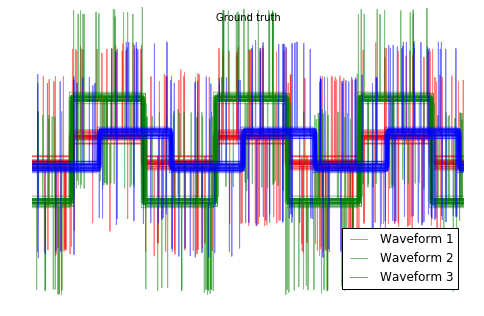

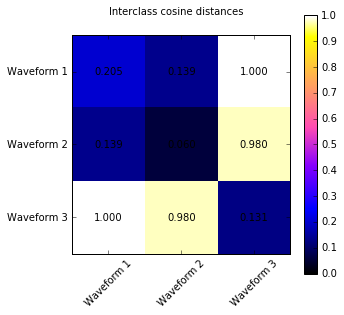

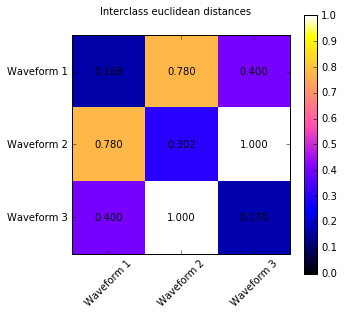

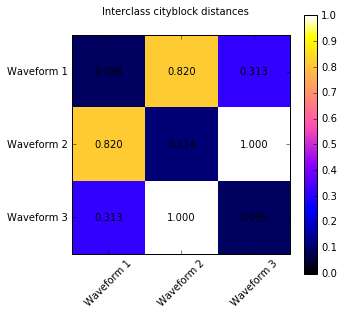

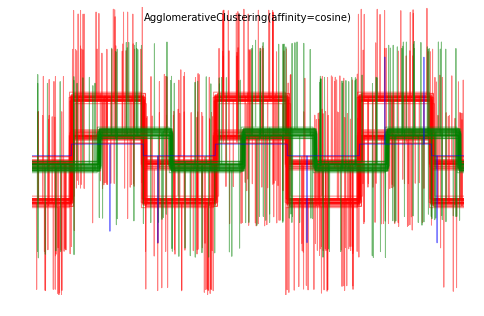

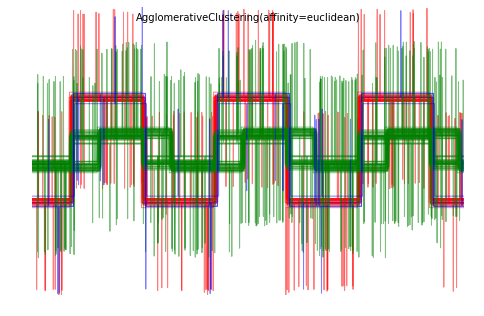

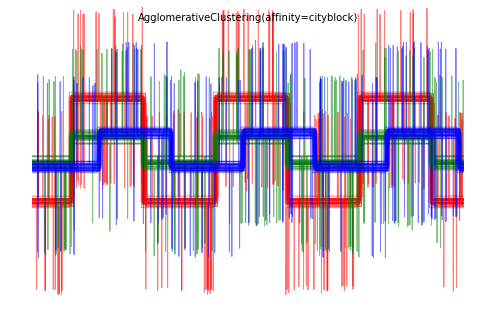

In [8]:
# 官方網站上的範例, 製照出波型圖資料, 並給定雜訊點, 以AgglomerativeClustering分群, 
# "cosine", "euclidean", "cityblock" 三種不同計算距離的方式去測試是否能把三種波型區隔開來, 結果只有cityblock方式可以完美區隔
# 而文章分群最好是以cosine算距離
# 所以要用什麼樣的算法確實都要一定程度的理解, 而不是概念性的下去亂用...


# Author: Gael Varoquaux
# License: BSD 3-Clause or CC-0

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))

X = list()
y = list()
for i, (phi, a) in enumerate([(.5, .15), (.5, .6), (.3, .2)]):
    for _ in range(30):
        phase_noise = .01 * np.random.normal()
        amplitude_noise = .04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < .997] = 0

        X.append(12 * ((a + amplitude_noise)
                 * (sqr(6 * (t + phi + phase_noise)))
                 + additional_noise))
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ('Waveform 1', 'Waveform 2', 'Waveform 3')

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), 'rgb',
                   labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=.5)
    lines[0].set_label(n)

plt.legend(loc='best')

plt.axis('tight')
plt.axis('off')
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(X[y == i], X[y == j],
                                                metric=metric).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(i, j, '%5.3f' % avg_dist[i, j],
                     verticalalignment='center',
                     horizontalalignment='center')

    plt.imshow(avg_dist, interpolation='nearest', cmap=plt.cm.gnuplot2,
               vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage="average", affinity=metric)
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()